# 20.8 Dimensionality and PCA

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Preparing the data</a></span><ul class="toc-item"><li><span><a href="#Dealing-with-missing-values" data-toc-modified-id="Dealing-with-missing-values-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Dealing with missing values</a></span></li><li><span><a href="#Dealing-with-outliers" data-toc-modified-id="Dealing-with-outliers-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Dealing with outliers</a></span></li></ul></li><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 2</a></span></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3</a></span></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Question 4</a></span></li><li><span><a href="#Question-5" data-toc-modified-id="Question-5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Question 5</a></span></li></ul></div>

**Assignment**

In this assignment, you'll continue working with the [U.S. Education Dataset](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home) from Kaggle. The data gives detailed state level information on the several facets of the state of education on annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link above. You should access the data from the Thinkful database. Below are the credentials you can use to connect to the database:

`postgres_user = 'dsbc_student' <br>
 postgres_pw = '7\*.8G9QH21'<br>
 postgres_host = '142.93.121.174'<br>
 postgres_port = '5432'<br>
 postgres_db = 'useducation' <br>

Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. You should provide your answers to the following questions after you handled the missing values.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

## Preparing the data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [8]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

In [10]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

data = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

### Dealing with missing values

In [11]:
data.isna().sum()/data.isna().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          0.176273
TOTAL_REVENUE                   0.142091
FEDERAL_REVENUE                 0.142091
STATE_REVENUE                   0.142091
LOCAL_REVENUE                   0.142091
TOTAL_EXPENDITURE               0.142091
INSTRUCTION_EXPENDITURE         0.142091
SUPPORT_SERVICES_EXPENDITURE    0.142091
OTHER_EXPENDITURE               0.176273
CAPITAL_OUTLAY_EXPENDITURE      0.142091
GRADES_PK_G                     0.115952
GRADES_KG_G                     0.088472
GRADES_4_G                      0.087802
GRADES_8_G                      0.087802
GRADES_12_G                     0.087802
GRADES_1_8_G                    0.087802
GRADES_9_12_G                   0.087802
GRADES_ALL_G                    0.115952
AVG_MATH_4_SCORE                0.640751
AVG_MATH_8_SCORE                0.643432
AVG_READING_4_SCORE             0.642761
AVG_READING_8_SC

In [162]:
data2 = data.copy()
print(id(data), id(data2))

112348180880 112441256592


We start by interpolating the missing data, and filling the remaining missing data using the average of the preceding and succeeding year.

In [163]:
years = list(data2['YEAR'].unique())
years.sort(reverse = True)

for state in data2['STATE'].unique():
    data2.loc[data2['STATE'] == state] = data2.loc[data2['STATE'] == state].interpolate() 
    
for state in data2['STATE'].unique():
    for year in years:
        cols_with_nans = data2.loc[(data2['YEAR'] == year) & (
            data2['STATE'] == state)].isna().any()
        cols_with_nans = list(cols_with_nans.loc[cols_with_nans == True].index)

        try:
            if len(cols_with_nans) > 0:
                for col in cols_with_nans:
                    if year > 1992 & year < 2017:  # first year on record
                        before = data2[col].loc[(
                            data2['YEAR'] == year - 1) & (data2['STATE'] == state)].values[0]
                        after = data2[col].loc[(
                            data2['YEAR'] == year + 1) & (data2['STATE'] == state)].values[0]

                        before_after_mean = np.nanmean([before, after])

                        data2[col].loc[(data2['YEAR'] == year) & (data2['STATE']
                                                                      == state)] = before_after_mean
                    if year == 1992:            
                        value_1993 = data2[col].loc[(data2['YEAR'] == 1993) & (data2['STATE']
                                                                      == state)].values[0]
                        data2[col].loc[(data2['YEAR'] == year) & (data2['STATE']
                                                                      == state)] = value_1993
                        
        except IndexError:
            pass
    
data2['YEAR'].loc[data2.isna().any(axis = 1)].value_counts()

2003    8
1999    8
2007    8
2006    8
2005    8
2004    8
2002    8
2001    8
2000    8
2013    7
2012    7
2011    7
2009    7
1998    7
1996    6
1997    6
2015    6
2010    6
2014    5
2008    5
1995    5
1994    5
1993    5
1992    5
Name: YEAR, dtype: int64

And we drop the remaining rows.

In [164]:
data2.dropna(inplace=True)
data2.isnull().sum()/data2.isnull().count()

PRIMARY_KEY                     0.0
STATE                           0.0
YEAR                            0.0
ENROLL                          0.0
TOTAL_REVENUE                   0.0
FEDERAL_REVENUE                 0.0
STATE_REVENUE                   0.0
LOCAL_REVENUE                   0.0
TOTAL_EXPENDITURE               0.0
INSTRUCTION_EXPENDITURE         0.0
SUPPORT_SERVICES_EXPENDITURE    0.0
OTHER_EXPENDITURE               0.0
CAPITAL_OUTLAY_EXPENDITURE      0.0
GRADES_PK_G                     0.0
GRADES_KG_G                     0.0
GRADES_4_G                      0.0
GRADES_8_G                      0.0
GRADES_12_G                     0.0
GRADES_1_8_G                    0.0
GRADES_9_12_G                   0.0
GRADES_ALL_G                    0.0
AVG_MATH_4_SCORE                0.0
AVG_MATH_8_SCORE                0.0
AVG_READING_4_SCORE             0.0
AVG_READING_8_SCORE             0.0
dtype: float64

### Dealing with outliers

We start by visualizing the outliers using Tukey's method.

In [165]:
states = data2['STATE'].unique()
states.sort()

In [166]:
all_cols = ['TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']

In [180]:
expenditures = ['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE']

exam_scores = ['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']


In [168]:
def tukeys_visualizers(dataframe, list_of_cols, only_outliers = False):
    
    return_test = False
    
    cols_with_outliers = []
    
    for col in list_of_cols:
        #print("Calculating outliers for:", col)
        q75, q25 = np.percentile(dataframe[col], [75, 25])
        iqr = q75 - q25

        outliers = []
        thresholds = []

        for threshold in np.arange(1, 15, 0.5):
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)

            outlier_count = len((np.where((dataframe[col] > max_val) | (dataframe[col] < min_val))[0]))

            outliers.append(outlier_count)
            thresholds.append(threshold)

        visuals = pd.Series(outliers, thresholds)
        
        if visuals[3.0] > 0:
            visuals.plot(label = col)
            
            cols_with_outliers.append(col)
            
            return_test = True
    
            plt.legend()
            plt.xlabel('IQR Threshold')
            plt.ylabel('Number of outliers')
            plt.xticks(ticks = range(1, 15))
                      
    if only_outliers:
        return (return_test, cols_with_outliers)

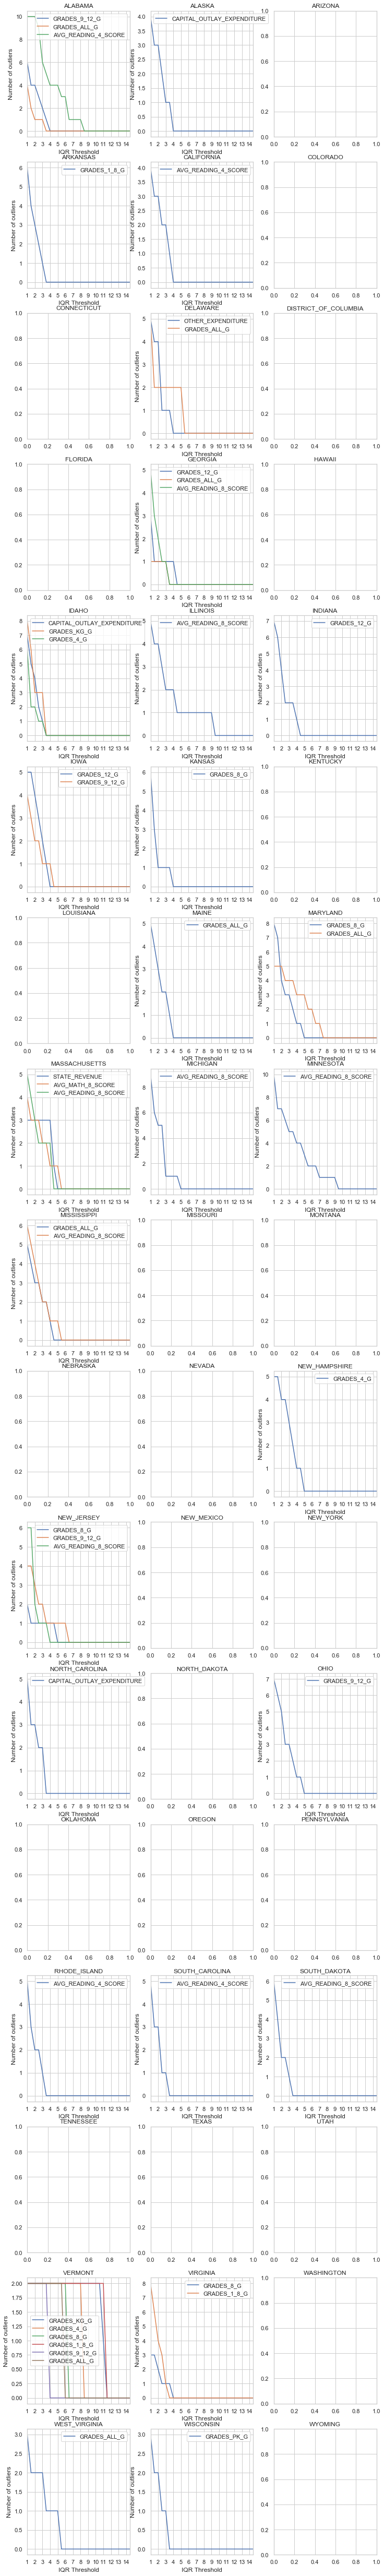

<Figure size 432x288 with 0 Axes>

In [169]:
plt.figure(figsize=(12, 95))

states_to_be_winsorized = {}

index = 1
for state in states:

    list_of_cols = expenditures

    does_state_have_outliers, outlying_variables = tukeys_visualizers(
        data2.loc[data2['STATE'] == state], all_cols, True)

    plt.subplot(18, 3, index)
    plt.title(state)
    index += 1

    if does_state_have_outliers:
        states_to_be_winsorized[state] = outlying_variables

plt.show()
plt.tight_layout()

In [170]:
states_to_be_winsorized

{'ALASKA': ['GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_READING_4_SCORE'],
 'ARIZONA': ['CAPITAL_OUTLAY_EXPENDITURE'],
 'CALIFORNIA': ['GRADES_1_8_G'],
 'COLORADO': ['AVG_READING_4_SCORE'],
 'DISTRICT_OF_COLUMBIA': ['OTHER_EXPENDITURE', 'GRADES_ALL_G'],
 'HAWAII': ['GRADES_12_G', 'GRADES_ALL_G', 'AVG_READING_8_SCORE'],
 'ILLINOIS': ['CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_KG_G', 'GRADES_4_G'],
 'INDIANA': ['AVG_READING_8_SCORE'],
 'IOWA': ['GRADES_12_G'],
 'KANSAS': ['GRADES_12_G', 'GRADES_9_12_G'],
 'KENTUCKY': ['GRADES_8_G'],
 'MARYLAND': ['GRADES_ALL_G'],
 'MASSACHUSETTS': ['GRADES_8_G', 'GRADES_ALL_G'],
 'MICHIGAN': ['STATE_REVENUE', 'AVG_MATH_8_SCORE', 'AVG_READING_8_SCORE'],
 'MINNESOTA': ['AVG_READING_8_SCORE'],
 'MISSISSIPPI': ['AVG_READING_8_SCORE'],
 'MISSOURI': ['GRADES_ALL_G', 'AVG_READING_8_SCORE'],
 'NEW_JERSEY': ['GRADES_4_G'],
 'NEW_MEXICO': ['GRADES_8_G', 'GRADES_9_12_G', 'AVG_READING_8_SCORE'],
 'NORTH_DAKOTA': ['CAPITAL_OUTLAY_EXPENDITURE'],
 'OKLAHOMA': ['GRADES_9_12_G'],
 

Now that we know the states and their outlying variables, we winsorize these variables at the 99th percentile.

In [241]:
data3 = data2.copy()
data3['corrected'] = ""

for col in all_cols:
    data3[col + '_corrected'] = ""
    
print(len(data3.columns))

49


In [242]:
for state in states:  
    corrected = False
    
    if state in states_to_be_winsorized:
        data3['corrected'].loc[data3['STATE'] == state] = 1
        corrected = True
    else:
        data3['corrected'].loc[data3['STATE'] == state] = 0
                
    for col in all_cols:
        if corrected and col in states_to_be_winsorized[state]:
            data3[col + '_corrected'].loc[data3['STATE'] == state] = winsorize(data3[col].loc[data3['STATE'] == state], limits = 0.01)
        else:
            data3[col + '_corrected'].loc[data3['STATE'] == state] = data3[col].loc[data3['STATE'] == state]

In [243]:
data3 = data3.drop(columns = all_cols)

all_cols = list(data3.columns)
all_cols.remove('PRIMARY_KEY')
all_cols.remove('corrected')
all_cols.remove('STATE')
all_cols

['YEAR_corrected',
 'ENROLL_corrected',
 'TOTAL_REVENUE_corrected',
 'FEDERAL_REVENUE_corrected',
 'STATE_REVENUE_corrected',
 'LOCAL_REVENUE_corrected',
 'TOTAL_EXPENDITURE_corrected',
 'INSTRUCTION_EXPENDITURE_corrected',
 'SUPPORT_SERVICES_EXPENDITURE_corrected',
 'OTHER_EXPENDITURE_corrected',
 'CAPITAL_OUTLAY_EXPENDITURE_corrected',
 'GRADES_PK_G_corrected',
 'GRADES_KG_G_corrected',
 'GRADES_4_G_corrected',
 'GRADES_8_G_corrected',
 'GRADES_12_G_corrected',
 'GRADES_1_8_G_corrected',
 'GRADES_9_12_G_corrected',
 'GRADES_ALL_G_corrected',
 'AVG_MATH_4_SCORE_corrected',
 'AVG_MATH_8_SCORE_corrected',
 'AVG_READING_4_SCORE_corrected',
 'AVG_READING_8_SCORE_corrected']

In [244]:
for col in all_cols:
    data3[col] = data3[col].astype('float')

In [245]:
data_ready = data3.copy()

Data is ready.

## Question 1

Create a new score variable from the weighted averages of all score variables in the datasets. **Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!**.

**Answer**

Since we have dealt with outlier and eliminiated

In [246]:
number_students = ['GRADES_PK_G_corrected', 'GRADES_KG_G_corrected', 'GRADES_4_G_corrected',
                   'GRADES_8_G_corrected', 'GRADES_12_G_corrected', 'GRADES_1_8_G_corrected',
                   'GRADES_9_12_G_corrected', 'GRADES_ALL_G_corrected']

test_scores = ['AVG_MATH_4_SCORE_corrected', 'AVG_MATH_8_SCORE_corrected',
               'AVG_READING_4_SCORE_corrected', 'AVG_READING_8_SCORE_corrected']

revenues = ['TOTAL_REVENUE_corrected', 'FEDERAL_REVENUE_corrected',
            'STATE_REVENUE_corrected', 'LOCAL_REVENUE_corrected']

expenditures = ['TOTAL_EXPENDITURE_corrected', 'INSTRUCTION_EXPENDITURE_corrected',
                'SUPPORT_SERVICES_EXPENDITURE_corrected', 'OTHER_EXPENDITURE_corrected',
                'CAPITAL_OUTLAY_EXPENDITURE_corrected']

In [247]:
data_ready['WEIGHTED_TEST_SCORE'] = 0

for col in test_scores:
    population = (data_ready['GRADES_4_G_corrected'] + data_ready['GRADES_8_G_corrected']) * 2
    
    if '4' in col:
        data_ready[col + '_weight'] =  data_ready['GRADES_4_G_corrected']/population
    else:
        data_ready[col + '_weight'] =  data_ready['GRADES_8_G_corrected']/population
        
    data_ready['WEIGHTED_TEST_SCORE'] += data_ready[col] * data_ready[col + '_weight']

data_ready.head()

,PRIMARY_KEY,STATE,corrected,YEAR_corrected,ENROLL_corrected,TOTAL_REVENUE_corrected,FEDERAL_REVENUE_corrected,STATE_REVENUE_corrected,LOCAL_REVENUE_corrected,TOTAL_EXPENDITURE_corrected,...,GRADES_ALL_G_corrected,AVG_MATH_4_SCORE_corrected,AVG_MATH_8_SCORE_corrected,AVG_READING_4_SCORE_corrected,AVG_READING_8_SCORE_corrected,WEIGHTED_TEST_SCORE,AVG_MATH_4_SCORE_corrected_weight,AVG_MATH_8_SCORE_corrected_weight,AVG_READING_4_SCORE_corrected_weight,AVG_READING_8_SCORE_corrected_weight
0,1992_ALABAMA,ALABAMA,0,1992.0,727716.0,2678885.0,304177.0,1659028.0,715680.0,2653798.0,...,676174.0,208.327876,252.187522,207.963517,260.276441,232.204803,0.249834,0.250166,0.249834,0.250166
1,1992_ALASKA,ALASKA,1,1992.0,121156.0,1049591.0,106780.0,720711.0,222100.0,972488.0,...,112335.0,223.833455,277.643071,211.547154,258.859712,241.662975,0.262934,0.237066,0.262934,0.237066
2,1992_ARIZONA,ARIZONA,1,1992.0,676297.0,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,...,614881.0,215.253932,265.366278,206.212716,262.169895,235.639070,0.265194,0.234806,0.265194,0.234806
3,1992_ARKANSAS,ARKANSAS,0,1992.0,311432.0,1711959.0,178571.0,958785.0,574603.0,1743022.0,...,405259.0,210.206028,256.312090,208.634458,264.619665,235.441283,0.245120,0.254880,0.245120,0.254880
4,1992_CALIFORNIA,CALIFORNIA,1,1992.0,5129788.0,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,...,4717112.0,208.398961,260.892247,196.764414,269.197451,231.610996,0.267629,0.232371,0.267629,0.232371


**Answer**

In [257]:
data_ready['WEIGHTED_TEST_SCORE'].describe()

count    1331.000000
mean      247.824390
std         7.474228
min       210.794614
25%       243.915900
50%       248.884356
75%       253.050180
max       264.696429
Name: WEIGHTED_TEST_SCORE, dtype: float64

## Question 2

What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

(6.0, 0.0)

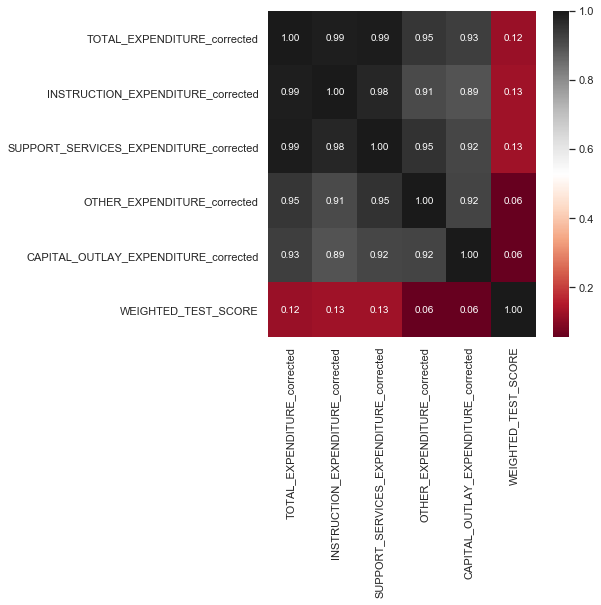

In [277]:
corr = data_ready[['TOTAL_EXPENDITURE_corrected', 'INSTRUCTION_EXPENDITURE_corrected',
                'SUPPORT_SERVICES_EXPENDITURE_corrected', 'OTHER_EXPENDITURE_corrected',
                'CAPITAL_OUTLAY_EXPENDITURE_corrected', 'WEIGHTED_TEST_SCORE']].corr()

plt.figure(figsize=(6, 6))
ax = sns.heatmap(corr, annot=True, fmt = '.2f', cmap='RdGy')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

**Answer**

Of the 5 expenditure variables, `INSTRUCTION_EXPENDITURE_corrected` and `SUPPORT_SERVICES_EXPENDITURE_corrected` are the most correlated. 

## Question 3
Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [282]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(data_ready[expenditures])

sklearn_pca = PCA(n_components=1)
data_ready['EXPENDITURE_PCA_1'] = sklearn_pca.fit_transform(X)

sklearn_pca.explained_variance_ratio_

array([0.95454712])

## Question 4
What is the correlation between the overall score variable and the 1st principal component? 

(7.0, 0.0)

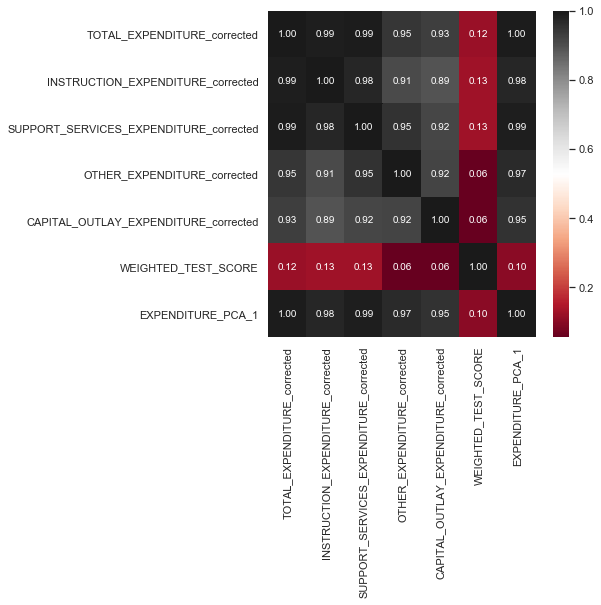

In [279]:
corr = data_ready[['TOTAL_EXPENDITURE_corrected', 'INSTRUCTION_EXPENDITURE_corrected',
                'SUPPORT_SERVICES_EXPENDITURE_corrected', 'OTHER_EXPENDITURE_corrected',
                'CAPITAL_OUTLAY_EXPENDITURE_corrected', 'WEIGHTED_TEST_SCORE', 'EXPENDITURE_PCA_1']].corr()

plt.figure(figsize=(6, 6))
ax = sns.heatmap(corr, annot=True, fmt = '.2f', cmap='RdGy')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

**Answers** 

As expected, the correlation between the PCA and the `WEIGHTED_TEST_SCORE` is less than the correlation between the EXPENDITURES on their own.

## Question 5
If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

(8.0, 0.0)

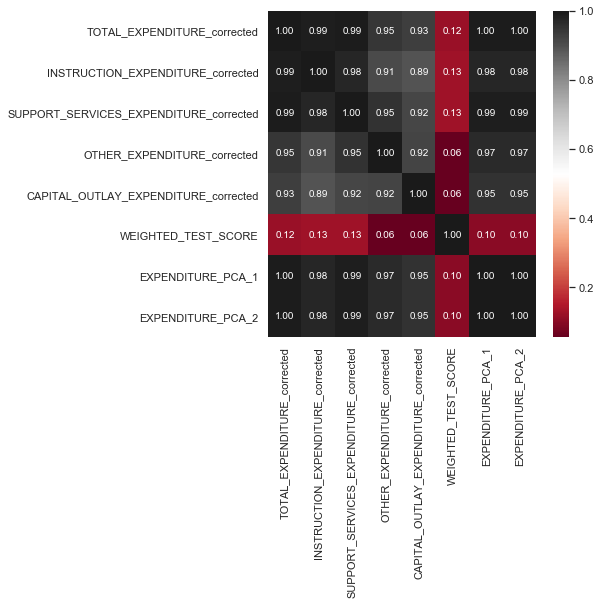

In [289]:
X = StandardScaler().fit_transform(data_ready[expenditures])

sklearn_pca = PCA(n_components=len(expenditures))
data_ready['EXPENDITURE_PCA_2'] = sklearn_pca.fit_transform(X)

corr = data_ready[['TOTAL_EXPENDITURE_corrected', 'INSTRUCTION_EXPENDITURE_corrected',
                'SUPPORT_SERVICES_EXPENDITURE_corrected', 'OTHER_EXPENDITURE_corrected',
                'CAPITAL_OUTLAY_EXPENDITURE_corrected', 'WEIGHTED_TEST_SCORE', 
                'EXPENDITURE_PCA_1', 'EXPENDITURE_PCA_2']].corr()

plt.figure(figsize=(6, 6))
ax = sns.heatmap(corr, annot=True, fmt = '.2f', cmap='RdGy')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

**Answers**

Even adding all of the explanatory variables created a PCA variable with a correlation less than the highest individual value. This is likely because the variables are highly intercorrelated (all corr > 0.8), and might lead to inaccurate estimations. 